# DISTANZA DI Hausdorff con Mask_RCNN
Nel seguente modulo useremo la distanza di Hausdorff per misurare quanto due insieme sono "vicini" tra loro.

In [38]:
# COMMON LIBRARIES
import os
import cv2
import requests
import json
import numpy as np
import torch
import random

import matplotlib.pyplot as plt
from datetime import datetime

from scipy.spatial.distance import cdist

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

In [39]:
# Percorsi ai file COCO
base_path = os.getcwd()

# Costruisci i percorsi relativi alla posizione dello script
json_file = os.path.join(base_path, "../../annotations", "instances_val2017.json")
image_folder = os.path.join(base_path, "../../val2017/")

# Nome dell'immagine di cui trovare la bounding box
image_filenames = "000000060449.jpg"

#Modello pre-addestrato
MODEL_USED = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

### Troviamo gli insiemi come GT e Prediction di un segmento in un'immagine

In [40]:
def extract_pixels_from_coco(image_filename, json_file):
    # 1. Caricare il file JSON con le annotazioni
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # 2. Creare una mappatura tra category_id e category_name
    category_dict = {category["id"]: category["name"] for category in coco_data["categories"]}

    # 3. Trovare i dati dell'immagine corrispondente al nome file
    image_data = next((img for img in coco_data["images"] if img["file_name"] == image_filename), None)

    if image_data is None:
        print("Immagine non trovata nel dataset COCO!")
        return []

    image_id = image_data["id"]
    image_width = image_data["width"]
    image_height = image_data["height"]

    # 4. Estrarre le segmentazioni associate a questa immagine
    extracted_data = []
    for ann in coco_data["annotations"]:
        if ann["image_id"] == image_id:
            category_id = ann["category_id"]
            category_name = category_dict.get(category_id, "Unknown")

            # Converte le segmentazioni in array di interi (ogni istanza può avere più poligoni)
            segmentation_pixels = [np.array(seg, dtype=np.int32).reshape((-1, 2)).tolist() for seg in ann["segmentation"]]

            extracted_data.append({
                "category_name": category_name,
                "pixels": segmentation_pixels,
                "image_width": image_width,
                "image_height": image_height
            })

    return extracted_data

def process_detectron2_output(image_path, model_used):
    # 1. Caricare l'immagine
    image = cv2.imread(image_path)
    
    # 2. Configurare il modello pre-addestrato di Detectron2
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_used))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Imposta la soglia di confidenza
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_used)
    cfg.MODEL.DEVICE = "cpu"  # Usa la CPU (puoi cambiare con 'cuda' se hai una GPU)
    
    # 3. Inizializzare il predittore
    predictor = DefaultPredictor(cfg)
    
    # 4. Eseguire il modello sull'immagine
    outputs = predictor(image)

    # 5. Estrarre le istanze predette (classi, bounding boxes)
    instances = outputs["instances"].to("cpu")
    
    # 6. Ottenere il metadata (nomi delle classi)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    
    # 7. Estrazione delle informazioni delle classi, bounding boxes e maschere
    category_ids = instances.pred_classes.numpy()  # ID delle classi
    bboxes = instances.pred_boxes.tensor.numpy()  # Bounding boxes
    masks = outputs["instances"].pred_masks.cpu().numpy()  # Shape: (N, H, W) (N=numero di istanze)
    
    # 8. Creare un array delle istanze predette con le informazioni desiderate
    boxes_predected = []
    
    for category_id, bbox, pred_mask in zip(category_ids, bboxes, masks):
        category_name = metadata.thing_classes[category_id]  # Ottieni il nome della categoria
        # Converti la maschera binaria in formato uint8
        mask_uint8 = (pred_mask * 255).astype(np.uint8)

        # Trova i contorni
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Converte i contorni in segmentazioni poligonali
        for contour in contours:
            if len(contour) > 2:  # Serve almeno un triangolo
                polygon = contour.reshape(-1, 2).tolist()  # Converte in lista di tuple [(x1,y1), (x2,y2), ...]
        
        # Aggiungi l'istanza al risultato
        boxes_predected.append({
            "category_name": category_name,
            "pixels": polygon,
            "image_width": image.shape[1],
            "image_height": image.shape[0]
        })

    return boxes_predected

def draw_mask(image_path, gt, predicted):
    image = cv2.imread(image_path)
    # Crea le maschere vuote per GT e PRED
    img_gt = np.ones_like(image) * 255  # Immagine bianca per GT
    img_pred = np.ones_like(image) * 255  # Immagine bianca per PRED

    # Disegna i poligoni sui canvas delle maschere
    gt_interpoled_255= np.array(gt, dtype=np.int32)
    pred_points_255 = np.array(predicted, dtype=np.int32)

    # Riempie il poligono GT con il colore rosso vivace (255, 0, 0)
    cv2.fillPoly(img_gt, [gt_interpoled_255], (255, 0, 0))

    # Riempie il poligono PRED con il colore blu vivace (0, 0, 255)
    cv2.fillPoly(img_pred, [pred_points_255], (0, 0, 255))

    # Sovrapponi le maschere sull'immagine originale con maggiore opacità
    overlay_gt = cv2.addWeighted(image, 0.7, img_gt, 0.3, 0)  # Aumenta l'opacità della maschera GT
    overlay_pred = cv2.addWeighted(overlay_gt, 1, img_pred, 0.3, 0)  # Sovrapponi anche la maschera PRED

    # Imposta la dimensione della figura
    plt.figure(figsize=(18, 6))

    # Mostra l'immagine originale con la maschera GT sovrapposta
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(overlay_gt, cv2.COLOR_BGR2RGB))
    plt.title("GT Overlay Interpoled (Red)")
    plt.axis('off')

    # Mostra l'immagine originale con la maschera PRED sovrapposta
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(overlay_pred, cv2.COLOR_BGR2RGB))
    plt.title("GT + PRED Overlay (Red + Blue)")
    plt.axis('off')

    # Mostra l'immagine originale senza maschera
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # Mostra le immagini affiancate
    plt.show()

In [41]:
pixel_gt = extract_pixels_from_coco(image_filenames, json_file)
pixel_predicted = process_detectron2_output(image_folder+image_filenames,MODEL_USED)

## Hausdorff
Siano X e Y due insiemi non vuoti in uno spazio metrico
la distanza di Hausdorff è definita come

$$ d_h(X,Y) =  max(h(X,Y),h(Y,X))

dove
$$ h(X,Y) = sup(inf(d(x,y): y \in Y): x \in X)

ossia il massimo tra le distanze minime tra ogni punto del primo insieme e cascun punto del secondo.

In [42]:
def height(Max,Min):
    """
    calcolo distanze minime tra ogni punto di Max e Min
    Args:
        Max (numpy.ndarray): Array di punti (N, 2).
        Min (numpy.ndarray): Array di punti (M, 2).
    """
    distance_matrix = cdist(Max, Min, metric="euclidean")

    # Trova la distanza minima per ogni punto di Max
    min_distances = np.min(distance_matrix, axis=1)

    return np.max(np.abs(min_distances))

def housdorff_distance(X,Y):
    """
    return: housedorf distance, percentage of housedorff distance
    """
    max_dim = max(np.max(X), np.max(Y))
    h_x = height(X,Y)
    h_y = height(Y,X)
    d_h = max(h_x,h_y)
    return d_h,  (d_h / max_dim) * 100

[{'distance': 92.97311439335567, 'distance_percentage': 16.513874670223032, 'insieme_gt': [[3, 434], [58, 420], [89, 461], [135, 475], [216, 455], [253, 442], [261, 442], [256, 459], [199, 476], [41, 493], [0, 479]], 'insieme_predicted': [[45, 422], [44, 423], [42, 423], [41, 424], [40, 424], [39, 425], [36, 425], [35, 426], [33, 426], [32, 427], [29, 427], [28, 428], [24, 428], [23, 429], [21, 429], [20, 430], [16, 430], [15, 431], [5, 431], [3, 433], [3, 438], [2, 439], [2, 491], [3, 492], [3, 493], [4, 494], [4, 496], [5, 497], [5, 498], [6, 499], [6, 500], [14, 508], [15, 508], [17, 510], [18, 510], [24, 516], [24, 517], [25, 518], [25, 519], [26, 519], [27, 520], [30, 520], [31, 521], [33, 521], [34, 522], [35, 522], [36, 523], [37, 523], [38, 524], [39, 524], [42, 527], [42, 528], [44, 530], [44, 531], [45, 532], [45, 534], [46, 534], [47, 535], [48, 535], [49, 536], [53, 536], [54, 537], [58, 537], [59, 538], [62, 538], [63, 539], [64, 539], [65, 540], [70, 540], [71, 541], [75,

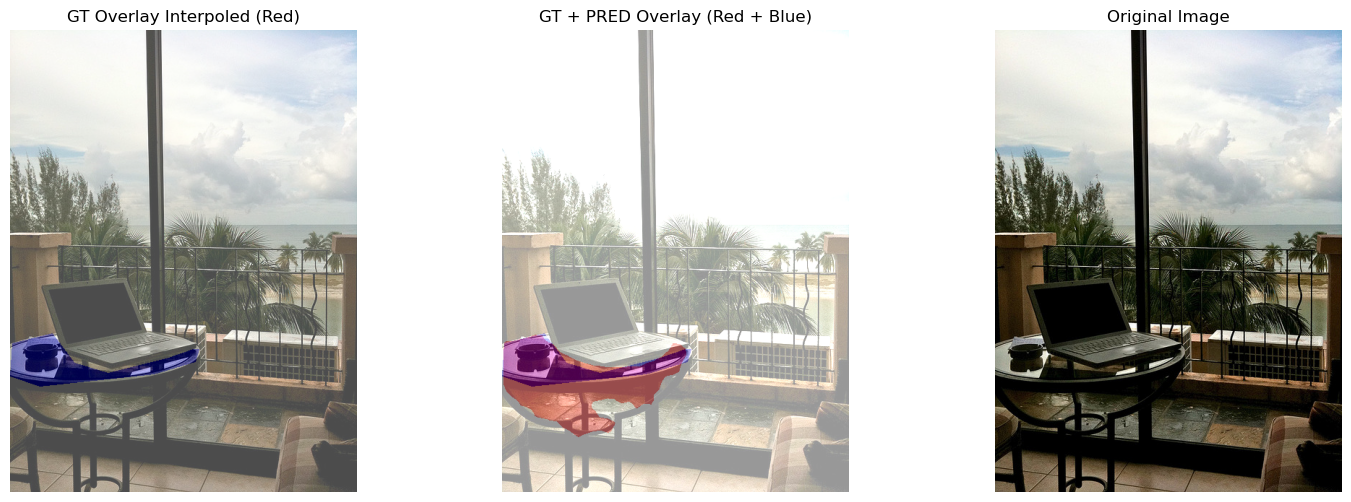

X elements:  11
Y elements:  338
La distanza di housedorf fra Gt e Predicted è  92.97311439335567
La distanza di housedorf fra Gt e Predicted in percentuale è  16.513874670223032 %
[{'distance': 52.3450093132096, 'distance_percentage': 11.13723602408715, 'insieme_gt': [[73, 448], [42, 354], [161, 342], [189, 416], [194, 416], [260, 435], [258, 443], [141, 470], [76, 449]], 'insieme_predicted': [[139, 344], [138, 345], [132, 345], [131, 346], [125, 346], [124, 347], [111, 347], [110, 348], [94, 348], [93, 349], [84, 349], [83, 350], [74, 350], [73, 351], [61, 351], [60, 352], [52, 352], [51, 353], [48, 353], [47, 354], [46, 354], [46, 355], [45, 356], [45, 357], [44, 358], [44, 367], [45, 368], [45, 370], [46, 371], [46, 372], [48, 374], [48, 375], [50, 377], [50, 378], [51, 379], [51, 383], [52, 384], [52, 386], [53, 387], [53, 388], [56, 391], [56, 392], [57, 393], [57, 394], [58, 395], [58, 397], [59, 398], [59, 404], [60, 405], [60, 407], [61, 408], [61, 410], [62, 411], [62, 412], 

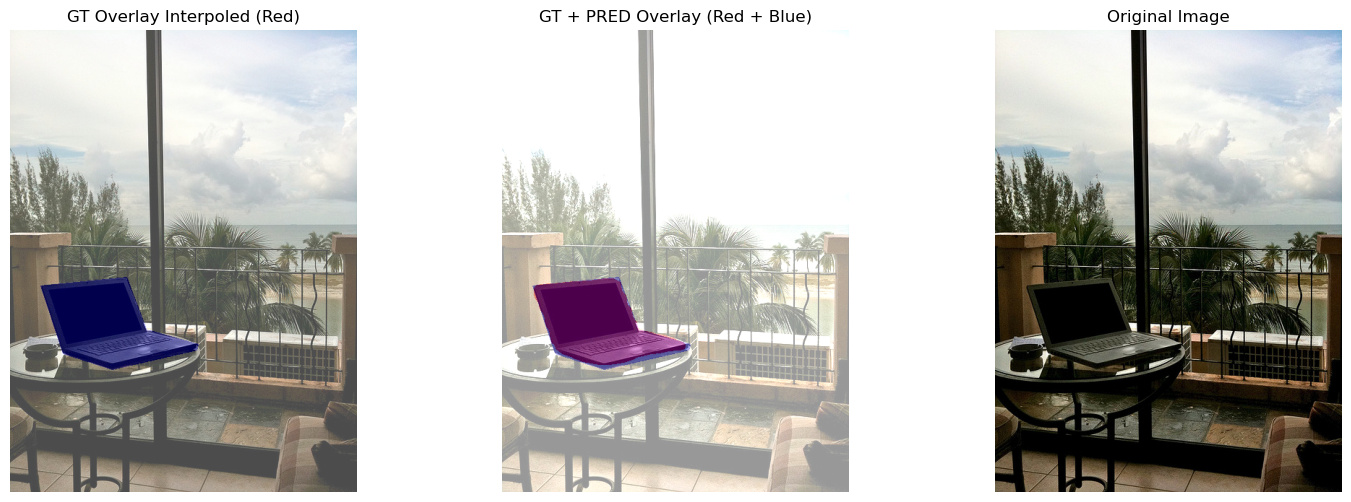

X elements:  9
Y elements:  222
La distanza di housedorf fra Gt e Predicted è  52.3450093132096
La distanza di housedorf fra Gt e Predicted in percentuale è  11.13723602408715 %
[{'distance': 21.02379604162864, 'distance_percentage': 3.2849681315044745, 'insieme_gt': [[2, 523], [15, 524], [25, 533], [31, 535], [32, 538], [37, 539], [37, 554], [37, 573], [37, 597], [38, 613], [40, 615], [40, 625], [40, 628], [41, 635], [41, 640], [27, 640], [26, 626], [4, 623], [1, 622], [0, 611], [28, 615], [25, 597], [21, 581], [7, 593], [0, 599], [0, 569], [0, 545], [0, 530], [0, 522], [2, 521]], 'insieme_predicted': [[2, 523], [1, 524], [1, 577], [0, 578], [0, 596], [1, 597], [1, 619], [3, 621], [5, 621], [6, 622], [7, 622], [8, 623], [9, 623], [10, 624], [11, 624], [12, 625], [15, 625], [16, 626], [18, 626], [19, 627], [22, 627], [23, 628], [24, 628], [27, 631], [27, 632], [28, 633], [28, 635], [29, 636], [29, 637], [32, 637], [33, 638], [38, 638], [39, 637], [40, 637], [41, 636], [41, 632], [40, 6

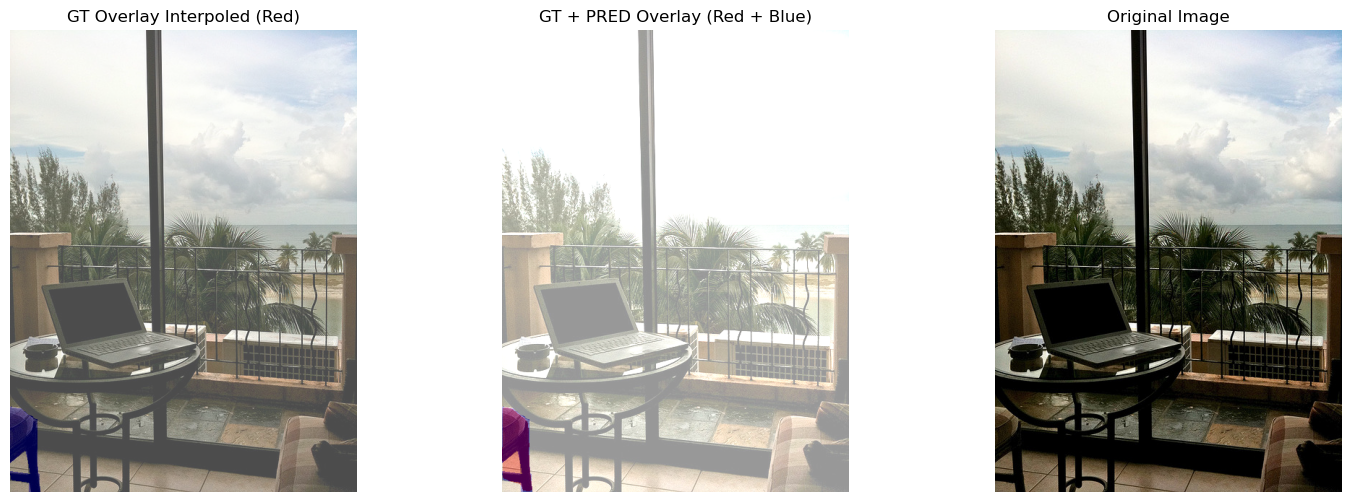

X elements:  30
Y elements:  69
La distanza di housedorf fra Gt e Predicted è  21.02379604162864
La distanza di housedorf fra Gt e Predicted in percentuale è  3.2849681315044745 %
[{'distance': 48.27007354458868, 'distance_percentage': 7.542198991341982, 'insieme_gt': [[364, 638], [480, 640], [480, 630], [480, 626], [437, 624], [426, 617], [416, 579], [420, 569], [436, 571], [463, 572], [466, 564], [435, 549], [433, 542], [432, 537], [400, 534], [385, 534], [379, 545], [368, 611], [362, 640]], 'insieme_predicted': [[445, 515], [443, 517], [442, 517], [441, 518], [441, 519], [440, 520], [440, 522], [439, 523], [439, 524], [438, 525], [438, 526], [437, 527], [437, 530], [436, 531], [436, 533], [433, 536], [410, 536], [409, 535], [391, 535], [390, 536], [387, 536], [386, 537], [385, 537], [381, 541], [381, 544], [380, 545], [380, 549], [379, 550], [379, 554], [378, 555], [378, 557], [377, 558], [377, 560], [376, 561], [376, 566], [375, 567], [375, 574], [374, 575], [374, 580], [373, 581],

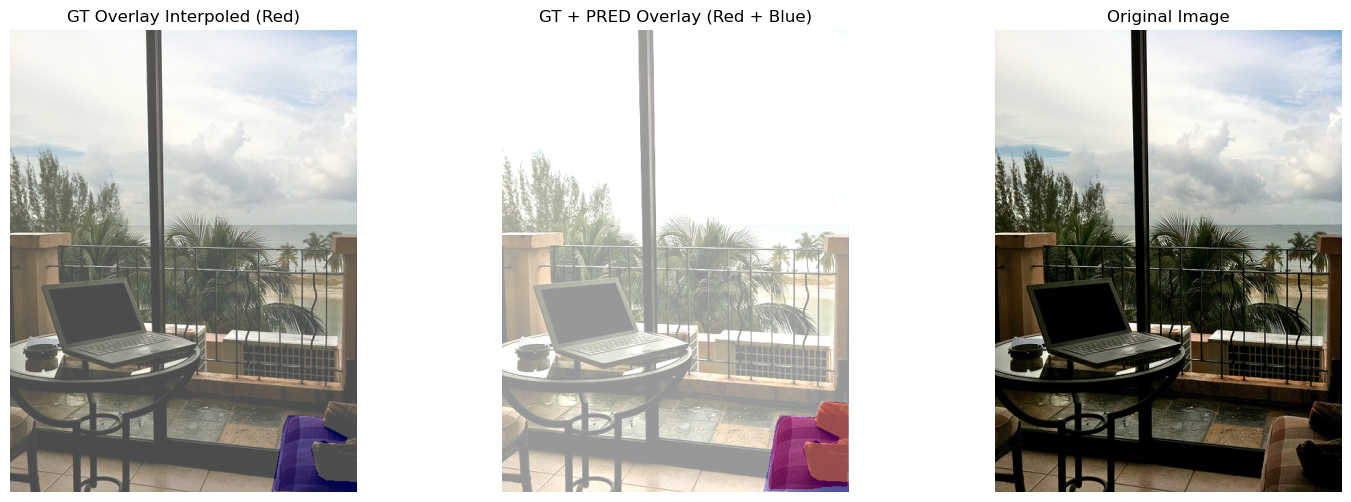

X elements:  19
Y elements:  75
La distanza di housedorf fra Gt e Predicted è  48.27007354458868
La distanza di housedorf fra Gt e Predicted in percentuale è  7.542198991341982 %
[{'distance': 444.7133908485329, 'distance_percentage': 69.48646732008326, 'insieme_gt': [[363, 640], [383, 538], [400, 533], [432, 533], [446, 510], [479, 512], [479, 638]], 'insieme_predicted': [[2, 523], [1, 524], [1, 577], [0, 578], [0, 596], [1, 597], [1, 619], [3, 621], [5, 621], [6, 622], [7, 622], [8, 623], [9, 623], [10, 624], [11, 624], [12, 625], [15, 625], [16, 626], [18, 626], [19, 627], [22, 627], [23, 628], [24, 628], [27, 631], [27, 632], [28, 633], [28, 635], [29, 636], [29, 637], [32, 637], [33, 638], [38, 638], [39, 637], [40, 637], [41, 636], [41, 632], [40, 631], [40, 625], [39, 624], [39, 616], [38, 615], [38, 606], [37, 605], [37, 589], [36, 588], [36, 578], [37, 577], [37, 572], [36, 571], [36, 551], [35, 550], [35, 544], [34, 543], [34, 542], [31, 539], [31, 538], [30, 537], [29, 537],

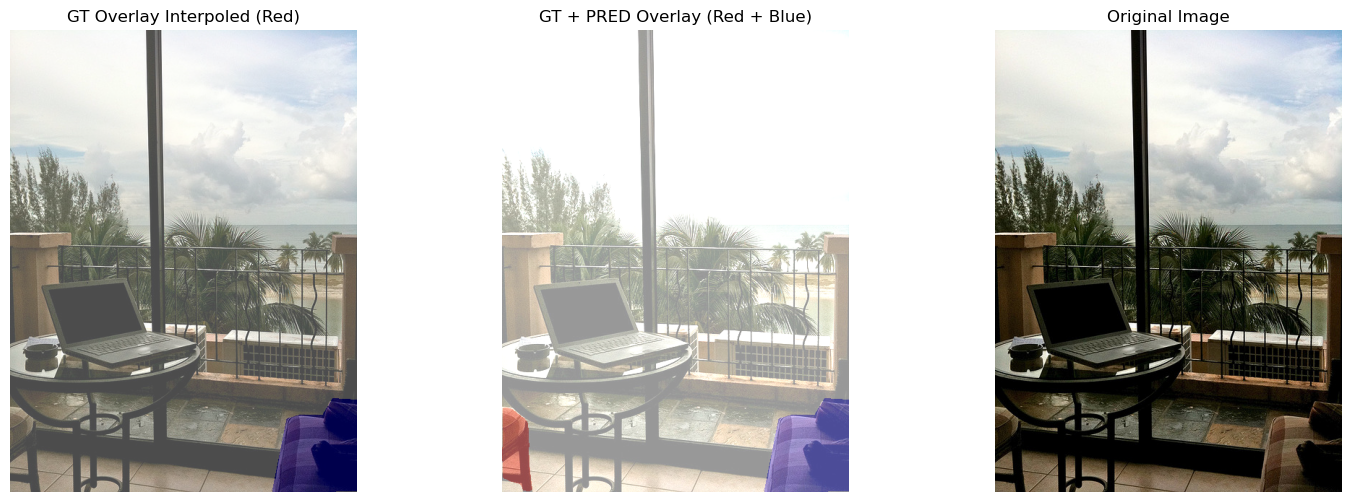

X elements:  7
Y elements:  69
La distanza di housedorf fra Gt e Predicted è  444.7133908485329
La distanza di housedorf fra Gt e Predicted in percentuale è  69.48646732008326 %


In [43]:
for gt in pixel_gt:
    #Trovo la corrispondenza più bassa
    for predected in pixel_predicted:
        if gt["category_name"] == predected["category_name"]:
            insieme_gt = gt["pixels"][0]
            insieme_predicted = predected["pixels"]

            temp_distances = np.array([], dtype=object)

            distance, distance_percentage = housdorff_distance(insieme_gt,insieme_predicted)
            temp_distances = np.append(temp_distances, {"distance":distance, "distance_percentage":distance_percentage, "insieme_gt":insieme_gt, "insieme_predicted":insieme_predicted})
            

    print(temp_distances)
    min_distance_book = min(temp_distances,key=lambda x: x["distance"])
    draw_mask(image_folder+image_filenames, min_distance_book["insieme_gt"], min_distance_book["insieme_predicted"])
    print("X elements: ", len(min_distance_book["insieme_gt"]))
    print("Y elements: ", len(min_distance_book["insieme_predicted"]))
    print("La distanza di housedorf fra Gt e Predicted è ", min_distance_book["distance"])
    print("La distanza di housedorf fra Gt e Predicted in percentuale è ", min_distance_book["distance_percentage"],"%")
        